# **02_Data Visualization**

## Objectives

**Provide ability to answer business requirement 1**

* The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.

* Eventually resize images.

## Inputs

* inputs/dataset/cherry_leaves_dataset/cherry-leaves/test
* inputs/dataset/cherry_leaves_dataset/cherry-leaves/train
* inputs/dataset/cherry_leaves_dataset/cherry-leaves/validation


## Outputs

* Create ability to answer for Business Requirements 1
* Image shape embeddings pickle file
* Mean and variability of images per label plot.
* Plots to differentiate between mildew-infected and uninfected leaves images.
* Create basis for an image montage on the Streamlit dashboard

---

# Set data directory

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

### Set working directory

Change the working directory from its current folder to its parent folder
> access the current directory with ```os.getcwd()```

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-mildew-detection/jupyter_notebooks'

Make the parent of the current directory the new current directory
> ```os.path.dirname()``` gets the parent directory; ```os.chir()``` defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-mildew-detection'

### Set input directories

Set train, validation an test paths.

In [5]:
my_data_dir = 'inputs/dataset/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

### Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data Visualization of image Data

---

## Image Shape

We will compute the average size on the train set.

First we analyze the the image dimensions and then plot the dimensions path.

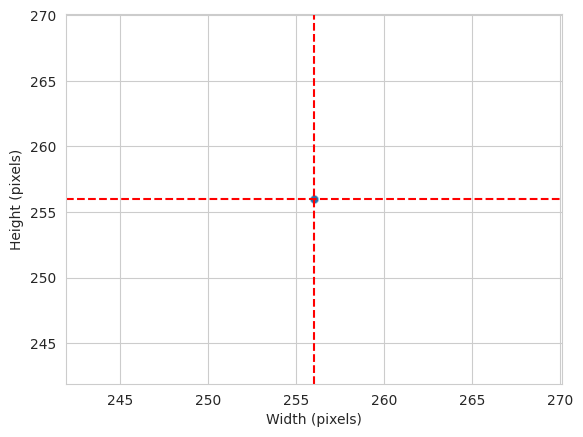

Width average: 256 
Height average: 256


In [8]:
# code for Data Visualization and its functions were adapted and taken from
# Walkthrough Project 01 Malaria Detector to analyze image dimensions and plot image dimension path

dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

This shows that the average image width as well as the average image height is 256px and all images he the same dimensin, which is the image size to train the model.

Below you can see the data regarding the image shape. The 256 numbers are already known to us. The third value dipicts the number of gradients - Red Green Blue Gradient (standard RGB colour range). 


In [9]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

The image shape is saved in the outputs folder.

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and variability of images per label

### Function to load images in an array (tensor)

We will define the mean and standard deviation of pixel values within mildew-infected leaves pictures and noninfected leaves pictures.

For this we define the function ```load_image_as_array```. In it we will load the image data as well their labels into an array. 

In [11]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 

from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):
    '''
    Load the image data from the directorty and the labels
    into an array. 
    It will return X for the array with the images and
    y for the array with the labels
    '''

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

2025-03-29 08:29:15.931871: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-29 08:29:16.904896: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we load our training data through this function into the variables ```X``` & ```y```.

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


### Plot and Save meand and variability of images per label

We define the function ```plot_mean_variability_per_labels``` in order to plot the mean and variability of images per mildew-infected- and healthy leaves images.

It takes the before defined ```X``` & ```y``` variables and the fig size. It loops over the labels and subsets of each label are created afterwards. Finally the meand and standard deviation is calculated. Images of them  are displayed and saved in the ```avg_diff``` iamge in the output folder

In [15]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 

def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

We call the function ```plot_mean_variability_per_labels``` with our data & the average and variabiliy ids displayed and saved to the output folder.

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


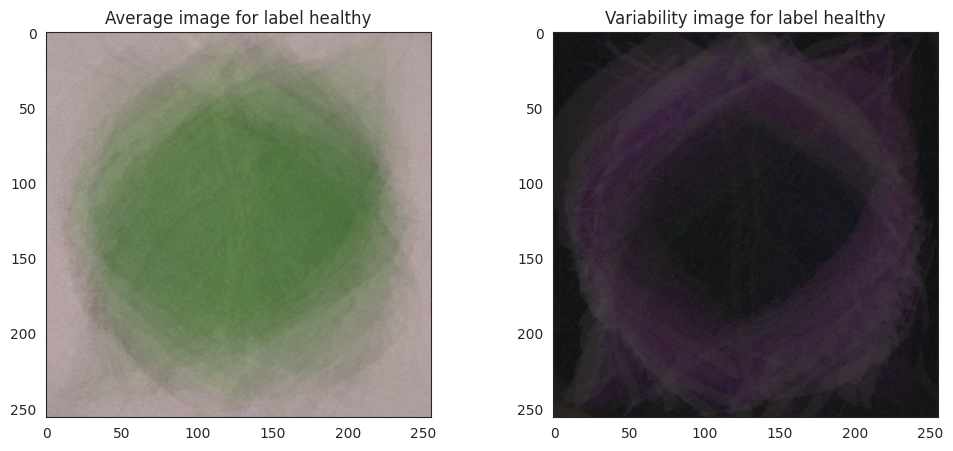

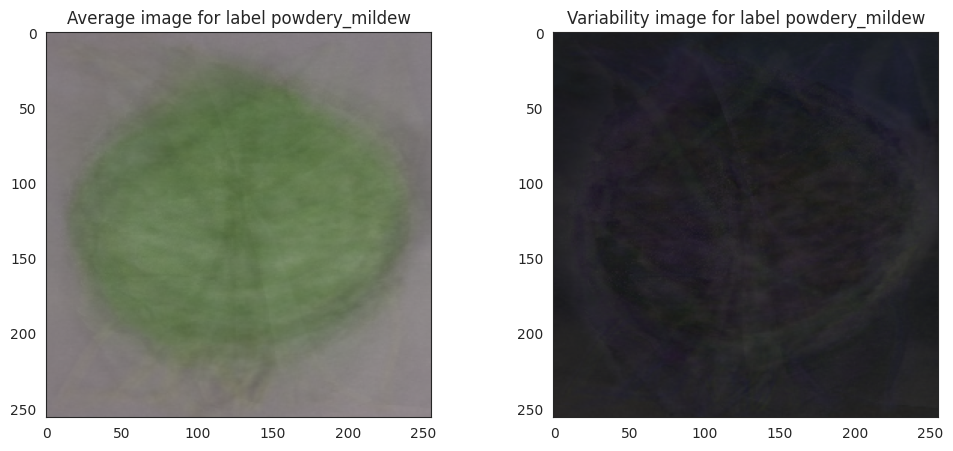

In [16]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

As can be seen the average image of mildew infected leaves is less highly greenly pigmented. A light white top coat can be seen as well which is not present ine the average healthy leave image. 

---

### Difference between average mildew-infected and average uninfected leaves images

We define the function ```subset_image_label``` to subset the image labels and the function ```diff_bet_avg_image_labels_data_as_array``` to check if the label is unique, calculate the difference between the average image labels, display the result and saves it in the output folder.

In [ ]:
# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detec

def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

We now call the function with our data and it saves the avg_diff.png to our output folder.

In [ ]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

Again you can see a more pigmented green in the average healthy image and a white top coat on the average mildew infected image.

---

### Image Montage

We define the function ```image_montage``` to create an image montage to display pictures from each label which will be used later on.

It checks if the labe exists and if more images are in the montage than the subset. We then create a list of axes indices, create a figure and plot the images to be displayed.

In [ ]:
import itertools
import random
sns.set_style("white")

# code for Data Visualization and its functions were adapted and taken from Walkthrough Project 01 Malaria Detector 

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    if the label exists in the directory
    check if your montage space is greater than the subset size
    create a list of axes indices based on nrows and ncols
    create a Figure and display images
    in this loop, load and plot the given image
    """

    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if label_to_display in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

We then call the function with our data, so the healhty and mildew infected images are displayed

In [ ]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---

## Outputs fullilled

* Business Requirements 1 can be answered as a study can now be created to visually differentiate a healthy cherry leaf from one with powdery mildew since images were examined throughout
* Image shape embeddings pickle file was created
* Mean and variability of images per label plot was created and displayed as well
* Plots were created to differentiate between mildew-infected and uninfected leaves images
* Image montage  was created which can be used later on the Streamlit dashboard
* There is a clear visual differene between healthy and mildew-infected images